In [1]:
from pathlib import Path
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import *


import polars as pl
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


ROOT_DIR = Path(os.getcwd()).parent

In [2]:
@dataclass
class PumpEvent:
    pump_id: int
    ticker: str
    time: str
    exchange: str

    def __post_init__(self):
        self.time: pd.Timestamp = pd.Timestamp(self.time)

    def __str__(self):
        return f"Pump event: {self.ticker} - {str(self.time)} on {self.exchange}"

In [3]:
# data is organized by days
pump = PumpEvent(
    pump_id=1, ticker="IDEXBTC", time="2021-04-25 17:00:10", exchange="binance"
)

def load_data(pump: PumpEvent, lookback_delta: timedelta) -> pd.DataFrame:

    start: pd.Timestamp = pump.time.floor("1h") - lookback_delta
    end: pd.Timestamp = pump.time.floor("1h")

    date_range: List[pd.Timestamp] = pd.date_range(
        start=start,
        end=end, freq="D",
        inclusive="both"
    ).tolist()

    df: pd.DataFrame = pd.DataFrame()

    for date in date_range:
        file_name: str = f"{pump.ticker}-trades-{date.date()}.parquet"
        df_date: pd.DataFrame = pd.read_parquet(
            os.path.join(
                ROOT_DIR, f"data/trades_parquet/{pump.exchange}/{pump.ticker}", file_name
            )
        )
        df = pd.concat([df, df_date])

    df["time"] = pd.to_datetime(df["time"], unit="ms")

    df = df[
        (df["time"] >= start) & (df["time"] < end - timedelta(minutes=5))
    ].reset_index(drop=True)

    return df

In [4]:
df: pd.DataFrame = load_data(pump=pump, lookback_delta=timedelta(days=30))
df["quote"] = df["price"] * df["qty"]

df.head()

,price,qty,time,isBuyerMaker,quote
0,0.000003,1588.0,2021-03-26 17:00:50.060,True,0.004018
1,0.000003,40.0,2021-03-26 17:00:50.060,True,0.000101
2,0.000003,5.0,2021-03-26 17:00:50.060,True,0.000013
3,0.000003,5839.0,2021-03-26 17:00:50.060,True,0.014714
4,0.000003,101.0,2021-03-26 17:01:36.193,False,0.000257


In [5]:
df["qty_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["qty"]
df["quote_sign"] = (1 - 2 * df["isBuyerMaker"]) * df["quote"]

df_trades: pd.DataFrame = df.groupby("time").agg(
    price_first=("price", "first"),
    price_last=("price", "last"),
    price_max=("price", "max"),
    price_min=("price", "min"),
    qty_sign=("qty_sign", "sum"),
    qty_abs=("qty", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_abs=("quote", "sum"),
    # Add BTC slippage
)

df_trades["is_long"] = df_trades["qty_sign"] >= 0

df_trades = df_trades.reset_index()
df_trades.head(2)

,time,price_first,price_last,price_max,price_min,qty_sign,qty_abs,quote_sign,quote_abs,is_long
0,2021-03-26 17:00:50.060,0.000003,0.000003,0.000003,0.000003,-7472.0,7472.0,-0.018846,0.018846,False
1,2021-03-26 17:01:36.193,0.000003,0.000003,0.000003,0.000003,2928.0,2928.0,0.007437,0.007437,True


<h3>Features</h3>

<h4>BTC slippage</h4>

$$\text{BTC\_lost\_to\_slippage} = \underbrace{\sum_{i=1}^{N}{\text{qty\_sign}_i} \cdot P_i}_{\text{Quote actually spent}} - \underbrace{\sum_{i=1}^N{\text{qty\_sign}_i} \cdot P_0}_{\text{Quote could have been spent if filled at best price}}$$

In [53]:
# find quote slippage for each trade
df_trades["quote_slippage_abs"] = (
    df_trades["quote_sign"] - df_trades["qty_sign"] * df_trades["price_first"]
)
df_trades["quote_slippage_sign"] = df_trades["quote_slippage_abs"] * np.sign(df_trades["qty_sign"])

<h4>1 Hour candlestick features</h4>

In [54]:
df_candles_1h: pd.DataFrame = df_trades.resample(on="time", rule="1h", label="left", closed="left").agg(
    open=("price_first", "first"),
    close=("price_last", "last"),
    low=("price_min", "min"),
    high=("price_max", "max"),
    num_trades=("quote_abs", "count"),
    num_long_trades=("is_long", "sum"),
    quote_abs=("quote_abs", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_slippage_abs=("quote_slippage_abs", "sum"),
    quote_slippage_sign=("quote_slippage_sign", "sum")
)

df_candles_1h.head(2)

,open,close,low,high,num_trades,num_long_trades,quote_abs,quote_sign,quote_slippage_abs,quote_slippage_sign
time,,,,,,,,,,
2021-03-26 17:00:00,0.000003,0.000003,0.000003,0.000003,333,239,1.478207,0.170128,0.001318,0.000762
2021-03-26 18:00:00,0.000003,0.000003,0.000002,0.000003,308,193,1.721219,0.307206,0.001925,0.001289


In [64]:
df_candles_1h["imbalance_ratio"] = df_candles_1h["quote_sign"] / df_candles_1h["quote_abs"]
df_candles_1h["long_trades_ratio"] = df_candles_1h["num_long_trades"] / df_candles_1h["num_trades"]
df_candles_1h["quote_slippage_imbalance_ratio"] = df_candles_1h["quote_slippage_sign"] / df_candles_1h["quote_slippage_abs"]

# calculate log returns
df_candles_1h["close"] = df_candles_1h["close"].ffill()
df_candles_1h["log_returns"] = np.log(df_candles_1h["close"] / df_candles_1h["close"].shift(1))
df_candles_1h = df_candles_1h.iloc[1:]
df_candles_1h = df_candles_1h.reset_index()

df_candles_1h.head(1)

,level_0,index,time,open,close,low,high,num_trades,num_long_trades,quote_abs,quote_sign,quote_slippage_abs,quote_slippage_sign,imbalance_ratio,long_trades_ratio,log_returns,log_returns_rolling_1d_std,log_returns_rolling_1d_mean,quote_slippage_imbalance_ratio
0,1,2,2021-03-26 20:00:00,0.000003,0.000003,0.000003,0.000003,533,326,4.462939,0.409428,0.009343,-0.002332,0.09174,0.611632,0.0,0.013732,0.014242,-0.249621


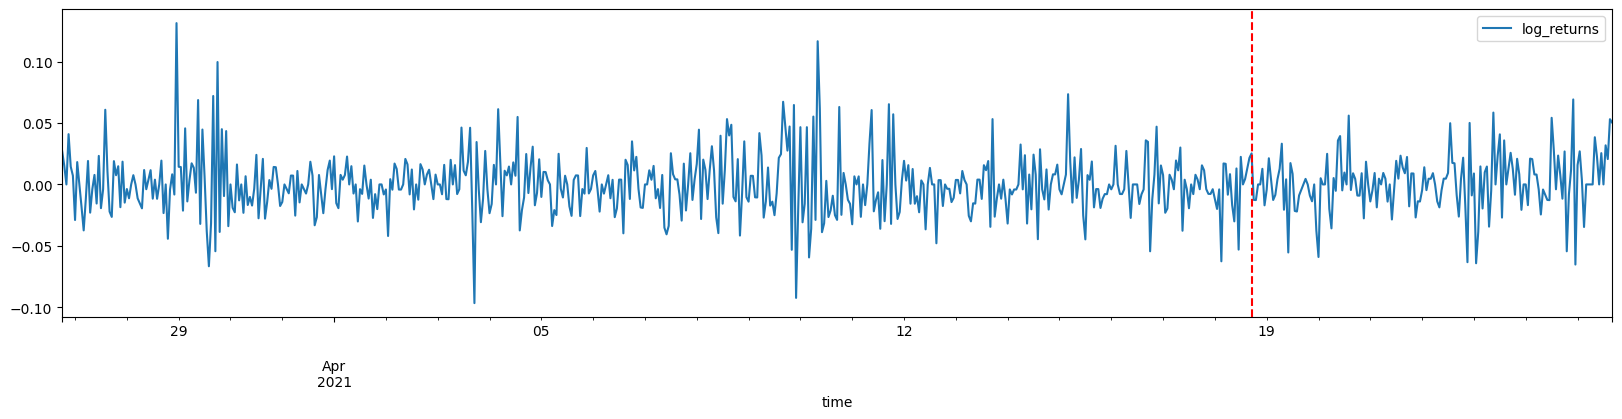

In [56]:
df_candles_1h.plot(x="time", y="log_returns", figsize=(20, 4))
plt.axvline(x=pump.time.floor("1h") - timedelta(days=7), color="red", linestyle="--")
plt.show()

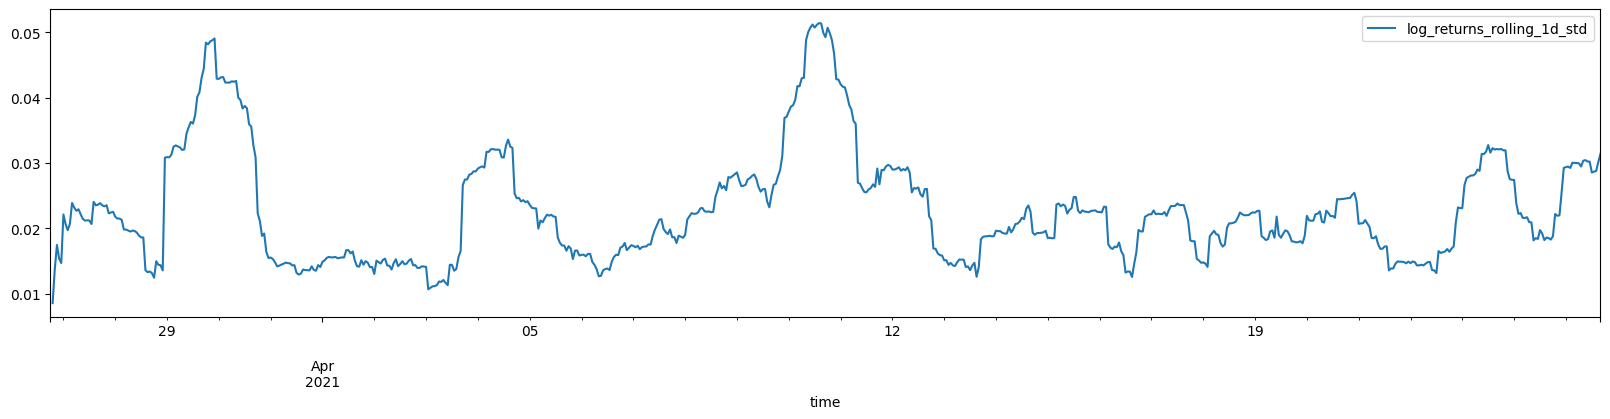

In [57]:
df_candles_1h["log_returns_rolling_1d_std"] = df_candles_1h.rolling(window="1d", on="time")["log_returns"].std()
df_candles_1h["log_returns_rolling_1d_mean"] = df_candles_1h.rolling(window="1d", on="time")["log_returns"].mean()

df_candles_1h.plot(x="time", y="log_returns_rolling_1d_std", figsize=(20, 4))
plt.show()

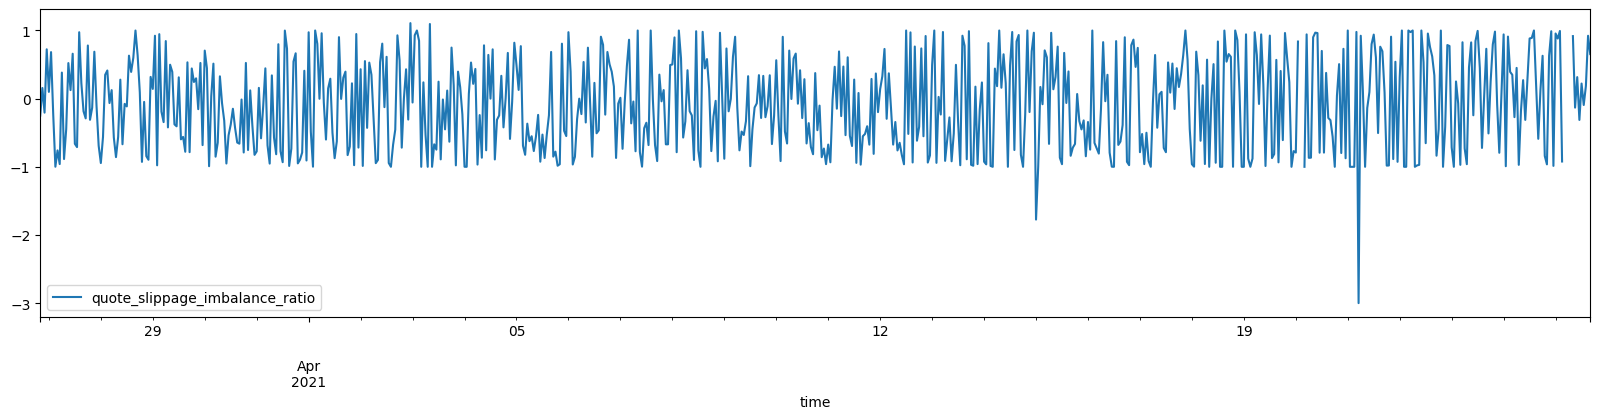

In [65]:
df_candles_1h.plot(x="time", y="quote_slippage_imbalance_ratio", figsize=(20, 4))
plt.show()

<h4>Overlapping interval features</h4>

In [21]:
df_30d: pd.DataFrame = df_candles_1h[
    df_candles_1h["time"] >= pump.time.floor("1h") - timedelta(days=30)
].copy()

In [79]:
offsets: List[timedelta] = [
    timedelta(days=i) for i in [1, 2, 5, 7, 14]
]

labels: List[str] = [
    f"{i}d" for i in [1, 2, 5, 7, 14]
]

hourly_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval = df_candles_1h[
        df_candles_1h["time"] >= pump.time.floor("1h") - offset
    ].copy()

    # Share of long trades scaled by long run moments 
    hourly_features[f"long_trades_1h_ratio_zscore_{label}"] = (
        df_interval["long_trades_ratio"].mean() - df_30d["long_trades_ratio"].mean()
    ) / df_30d["long_trades_ratio"].std()
    hourly_features[f"long_trades_1h_ratio_overall_{label}"] = df_interval["num_long_trades"].sum() / df_interval["num_trades"].sum()
    
    # Imbalance ratio features
    hourly_features[f"imbalance_ratio_1h_mean_{label}"] = df_interval["imbalance_ratio"].mean()
    hourly_features[f"imbalance_ratio_1h_std_{label}"] = df_interval["imbalance_ratio"].std()

    # Log returns features
    hourly_features[f"log_returns_1h_zscore_{label}"] = df_interval["log_returns"].mean() / df_30d["log_returns"].std()
    hourly_features[f"log_returns_1h_std_{label}"] = df_interval["log_returns"].std()

    hourly_features[f"quote_abs_1h_zscore_{label}"] = (
        df_interval["quote_abs"].mean() - df_30d["quote_abs"].mean()
    ) / df_30d["quote_abs"].std()

    # Quote slippage features
    hourly_features[f"quote_slippage_imbalance_ratio_1h_mean_{label}"] = df_interval["quote_slippage_imbalance_ratio"].mean()
    hourly_features[f"quote_slippage_imbalance_ratio_1h_std_{label}"] = df_interval["quote_slippage_imbalance_ratio"].std()
    # find slippage imbalance ratio over the whole interval
    hourly_features[f"quote_slippage_imbalance_ratio_1h_overall_{label}"] = (
        df_interval["quote_slippage_sign"].sum() / df_interval["quote_slippage_abs"].sum()
    )
    # Share of slippage in the whole volume
    hourly_features[f"quote_slippage_1h_quote_abs_ratio_{label}"] = df_interval["quote_slippage_abs"].sum() / df_interval["quote_abs"].sum()

    # Min, max features
    # Imbalance ratios
    hourly_features[f"imbalance_ratio_1h_max_{label}"] = df_interval["imbalance_ratio"].max()
    hourly_features[f"imbalance_ratio_1h_min_{label}"] = df_interval["imbalance_ratio"].min()
    # log returns
    hourly_features[f"log_returns_1h_max_{label}"] = df_interval["log_returns"].max()
    hourly_features[f"log_returns_1h_min_{label}"] = df_interval["log_returns"].min()
    # long_trades_ratio
    hourly_features[f"long_trades_1h_ratio_max_{label}"] = df_interval["long_trades_ratio"].max()
    hourly_features[f"long_trades_1h_ratio_min_{label}"] = df_interval["long_trades_ratio"].min()
    # quote_abs
    hourly_features[f"quote_abs_1h_max_scaled_median_{label}"] = df_interval["quote_abs"].max() / df_30d["quote_abs"].median()

In [80]:
len(hourly_features.keys())

90

<h4>Powerlaw features</h4>

In [81]:
from scipy.stats import powerlaw

In [83]:
powerlaw_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_trades[
        (df_trades["time"] >= pump.time.floor("1h") - offset)
    ].copy()

    # Compute alpha of powerlaw distribution for quote_abs, quote_long, quote_short
    powerlaw_features[f"quote_abs_powerlaw_alpha_{label}"] = powerlaw.fit(df_interval["quote_abs"])[0]
    # alpha for long trades
    powerlaw_features[f"long_quote_abs_powerlaw_alpha_{label}"] = powerlaw.fit(
        df_interval[df_interval["is_long"]]["quote_abs"]
    )[0]
    # alpha for short trades
    powerlaw_features[f"short_quote_abs_powerlaw_alpha_{label}"] = powerlaw.fit(
        df_interval[~df_interval["is_long"]]["quote_abs"]
    )[0]

len(powerlaw_features)

15

<h4>TSFresh features</h4>

In [86]:
from tsfresh.feature_extraction.feature_calculators import benford_correlation


benford_features: Dict[str, float] = {}


for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_trades[
        (df_trades["time"] >= pump.time.floor("1h") - offset)
    ].copy()

    # Benford correlation
    benford_features[f"benford_law_correlation_{label}"] = benford_correlation(df_interval["qty_abs"])


len(benford_features)

5

<h4>Quote quantity features</h4>

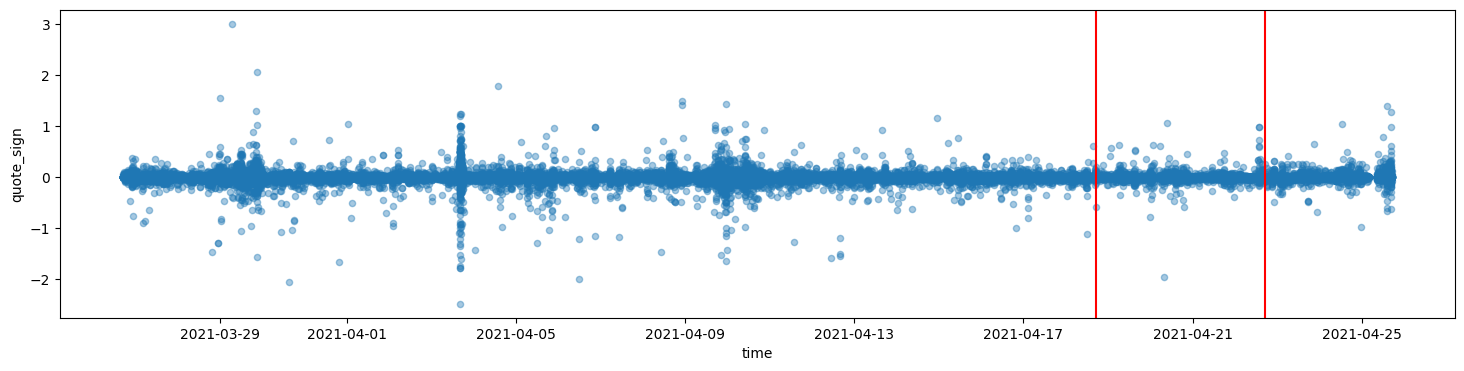

In [87]:
df_trades.plot.scatter(
    x="time", y="quote_sign", figsize=(18, 4), alpha=.4
)

plt.axvline(x=pump.time.floor("1h") - timedelta(days=7), color="red")
plt.axvline(x=pump.time.floor("1h") - timedelta(days=3), color="red")

plt.show()

In [110]:
quote_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_trades[
        (df_trades["time"] >= pump.time.floor("1h") - offset)
    ].copy()

    df_long: pd.DataFrame = df_interval[df_interval["is_long"]].copy()
    df_short: pd.DataFrame = df_interval[~df_interval["is_long"]].copy()

    # 999 quantiles
    long_whale_quantile: float = df_long["quote_abs"].quantile(.999)
    short_whale_quantile: float = df_short["quote_abs"].quantile(.999)
    whale_quantile: float = df_interval["quote_sign"].quantile(.999)

    # 99 quantiles
    long_99_quantile: float = df_long["quote_abs"].quantile(.99)
    short_99_quantile: float = df_short["quote_abs"].quantile(.99)
    quantile_99: float = df_interval["quote_sign"].quantile(.99)

    # 95 quantiles
    long_95_quantile: float = df_long["quote_abs"].quantile(.95)
    short_95_quantile: float = df_short["quote_abs"].quantile(.95)
    quantile_95: float = df_interval["quote_sign"].quantile(.95)

    long_median_quote: float = df_long["quote_abs"].median()
    short_nedian_quote: float = df_short["quote_abs"].median()

    quote_features[f"long_whale_99_ratio_{label}"] = long_whale_quantile / long_99_quantile # how spread out long quantiles become
    quote_features[f"short_whale_99_ratio_{label}"] = short_whale_quantile / short_99_quantile
    quote_features[f"long_whale_short_whale_ratio_{label}"] = long_whale_quantile / short_whale_quantile # how extended is long quantile compared to short

    quote_features[f"long_99_long_95_ratio_{label}"] = long_99_quantile / long_95_quantile
    quote_features[f"short_99_95_ratio_{label}"] = short_99_quantile / short_95_quantile
    quote_features[f"long_99_short_99_ratio_{label}"] = long_99_quantile / short_99_quantile

    quote_features[f"long_whale_median_ratio_{label}"] = long_whale_quantile / long_median_quote
    quote_features[f"short_whale_median_ratio_{label}"] = short_whale_quantile / short_nedian_quote


len(quote_features)

40

<h4>Empty trading intervals features</h4>

<p>Share of trading minutes which were empty. Expects that tickers with low volume are typically a target and closer to the pump this becomes lower</p>

In [124]:
# rebin data into 1min candles
df_candles_1min: pd.DataFrame = df_trades.resample(on="time", rule="1min", label="left", closed="left").agg(
    open=("price_first", "first"),
    close=("price_last", "last"),
    low=("price_min", "min"),
    high=("price_max", "max"),
    num_trades=("quote_abs", "count"),
    num_long_trades=("is_long", "sum"),
    quote_abs=("quote_abs", "sum"),
    quote_sign=("quote_sign", "sum"),
    quote_slippage_abs=("quote_slippage_abs", "sum"),
    quote_slippage_sign=("quote_slippage_sign", "sum")
).reset_index()

df_candles_1min.head(2)

,time,open,close,low,high,num_trades,num_long_trades,quote_abs,quote_sign,quote_slippage_abs,quote_slippage_sign
0,2021-03-26 17:00:00,0.000003,0.000003,0.000003,0.000003,1,0,0.018846,-0.018846,0.000058,-0.000058
1,2021-03-26 17:01:00,0.000003,0.000003,0.000003,0.000003,3,2,0.011546,0.003729,0.000005,-0.000005


In [125]:
empty_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_candles_1min[
        (df_candles_1min["time"] >= pump.time.floor("1h") - offset)
    ].copy()

    empty_features[f"empty_trading_minutes_ratio_{label}"] = df_interval[df_interval["num_trades"] == 0].shape[0] / df_interval.shape[0]

empty_features

{'empty_trading_minutes_ratio_1d': 0.3386759581881533,
 'empty_trading_minutes_ratio_2d': 0.2977391304347826,
 'empty_trading_minutes_ratio_5d': 0.28297428769979155,
 'empty_trading_minutes_ratio_7d': 0.2803970223325062,
 'empty_trading_minutes_ratio_14d': 0.23120813693872488}

<h4>Short run features</h4>

<p>Calculate similar features 24 hours prior to the pump</p>

In [145]:
df_trades_1d: pd.DataFrame = df_trades[
    df_trades["time"] >= pump.time.floor("1h") - timedelta(days=1)
].copy()

df_long: pd.DataFrame = df_trades_1d[df_trades_1d["is_long"]].copy()
df_short: pd.DataFrame = df_trades_1d[~df_trades_1d["is_long"]].copy()

# Calculate long and short rolling quantiles
df_long["quote_abs_rolling_999"] = df_long.rolling(on="time", window="1h")["quote_abs"].quantile(.999)
df_short["quote_abs_rolling_999"] = -df_short.rolling(on="time", window="1h")["quote_abs"].quantile(.999)

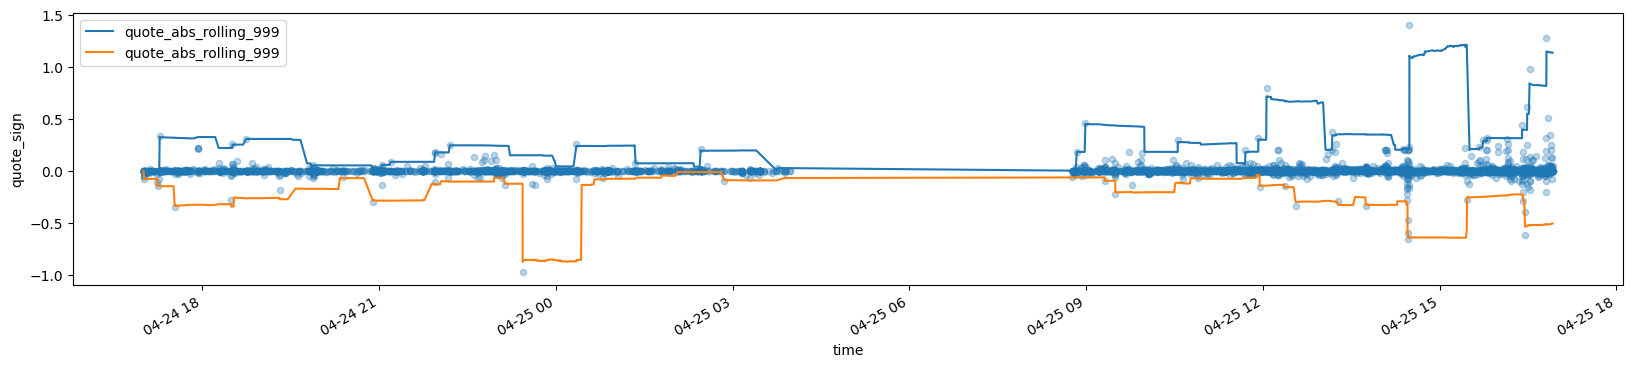

In [146]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)

df_trades_1d.plot.scatter(x="time", y="quote_sign", ax=ax, alpha=.3)
df_long.plot(x="time", y="quote_abs_rolling_999", ax=ax)
df_short.plot(x="time", y="quote_abs_rolling_999", ax=ax)

plt.show()

In [156]:
offsets: List[timedelta] = [
    timedelta(hours=i) for i in [1, 2, 5, 7, 12]
]

labels: List[str] = [
    f"{i}h" for i in [1, 2, 5, 7, 12]
]

short_features: Dict[str, float] = {}

for offset, label in zip(offsets, labels):
    df_interval: pd.DataFrame = df_trades_1d[
        df_trades_1d["time"] >= pump.time.floor("1h") - offset
    ].copy()

    df_long: pd.DataFrame = df_interval[df_interval["is_long"]].copy()
    df_short: pd.DataFrame = df_interval[~df_interval["is_long"]].copy()

    # Share of long trades within the time interval and the whole day 
    short_features[f"long_trades_ratio_{label}"] = df_interval["is_long"].sum() / df_interval.shape[0]
    short_features[f"long_trades_ratio_{label}_1d"] = df_interval["is_long"].sum() / df_trades_1d.shape[0]
    # Share of volume within the time interval and the whole day
    short_features[f"quote_abs_ratio_{label}_1d"] = df_interval["quote_abs"].sum() / df_trades_1d["quote_abs"].sum()
    short_features[f"quote_abs_long_ratio_{label}_1d"] = df_long["quote_abs"].sum() / df_interval["quote_abs"].sum()
    # Imbalance ratio
    short_features[f"imbalance_ratio_{label}"] = df_interval["quote_sign"].sum() / df_interval["quote_abs"].sum()
    # Quote slippage features
    short_features[f"quote_slippage_ratio_{label}_1d"] = df_interval["quote_slippage_abs"].sum() / df_trades_1d["quote_slippage_abs"].sum() # share of overall slippage
    short_features[f"quote_slippage_imbalance_ratio_{label}"] = df_interval["quote_slippage_sign"].sum() / df_interval["quote_slippage_abs"].sum()
    # Share of slippage quote compared to volume
    short_features[f"quote_slippage_quote_abs_ratio_{label}"] = df_interval["quote_slippage_abs"].sum() / df_interval["quote_abs"].sum()


len(short_features)

40